# Visualization of data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress

# Paths to the data and correlation results
dirs = ["res6", "res8"]
names = ["MGS1_SD6", "MGS1_SD8"]
paths_data = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/results.csv" for dir in dirs]
paths_corr = [f"/mnt/c/Users/Elena/Desktop/Data_processing/020226_U2OS2_fixed_MGS1/{dir}/spearman_pairs.csv" for dir in dirs]

# Load data and correlation results into dictionaries
dfs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_data)
}

corrs = {
    name: pd.read_csv(path)
    for name, path in zip(names, paths_corr)
}

# Combine dataframes and add a 'Group' column
combined = []
for name, df in dfs.items():
    temp = df.copy()
    temp["Group"] = name
    combined.append(temp)
combined_df = pd.concat(combined, ignore_index=True)


# Graphs

## Boxplots

In [2]:
def plot_publication_boxplots(
    dfs,
    combined_df,
    variables,
    y_labels,
    log_vars=None,
    figsize=(4.2, 4.2),
    dpi=200
):
    """
    Publication-style transparent boxplots with black jitter dots.

    Parameters:
        dfs : dict of {group_name: dataframe}
        combined_df : long-format dataframe with column 'Group'
        variables : list of column names to plot
        y_labels : dict {variable: y-axis label}
        log_vars : set of variables to log-scale (optional)
        figsize : tuple
        dpi : int
    """

    if log_vars is None:
        log_vars = set()

    def clean_axes(ax):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", direction="out", length=4, width=1)
        ax.grid(False)

    groups = list(dfs.keys())
    group1, group2 = groups[0], groups[1]

    for var in variables:

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        data1 = combined_df.loc[combined_df["Group"] == group1, var].dropna()
        data2 = combined_df.loc[combined_df["Group"] == group2, var].dropna()

        # ---- Transparent boxplot ----
        bp = ax.boxplot(
            [data1.values, data2.values],
            widths=0.55,
            showfliers=False,
            patch_artist=True,
            medianprops=dict(linewidth=2.0, color="black"),
            boxprops=dict(linewidth=1.6, color="black"),
            whiskerprops=dict(linewidth=1.6, color="black"),
            capprops=dict(linewidth=1.6, color="black")
        )

        for b in bp["boxes"]:
            b.set_facecolor("none")

        # ---- Black jitter dots ----
        jitter = 0.08
        x1 = np.random.normal(1, jitter, size=len(data1))
        x2 = np.random.normal(2, jitter, size=len(data2))

        ax.scatter(x1, data1, s=18, color="black", alpha=0.6, zorder=3)
        ax.scatter(x2, data2, s=18, color="black", alpha=0.6, zorder=3)

        # Labels
        labels = [group1.replace("_", " "), group2.replace("_", " ")]
        ax.set_xticks([1, 2])
        ax.set_xticklabels(labels, fontsize=10)

        ax.set_ylabel(y_labels.get(var, var), fontsize=11)
        ax.set_title(var.replace("_", " "), fontsize=12, pad=8)

        if var in log_vars:
            ax.set_yscale("log")

        clean_axes(ax)
        fig.tight_layout()
        plt.show()


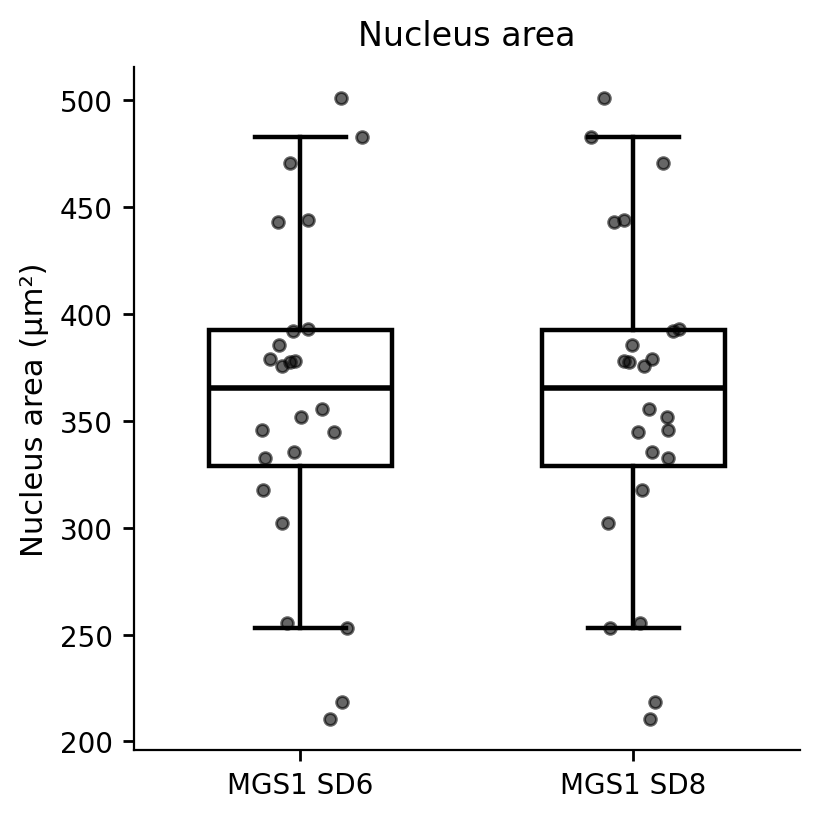

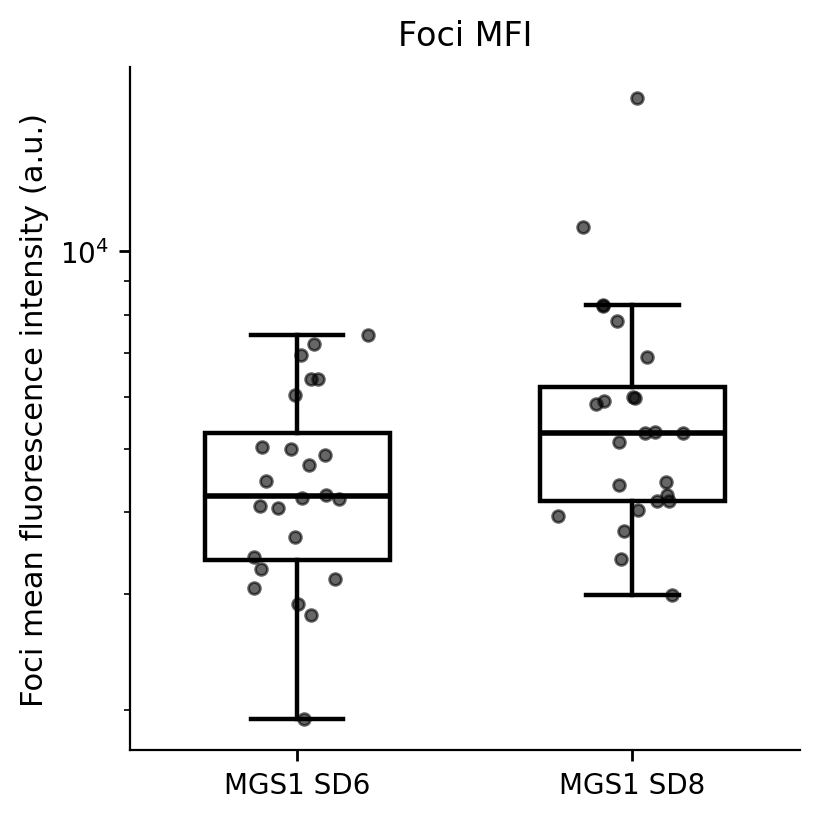

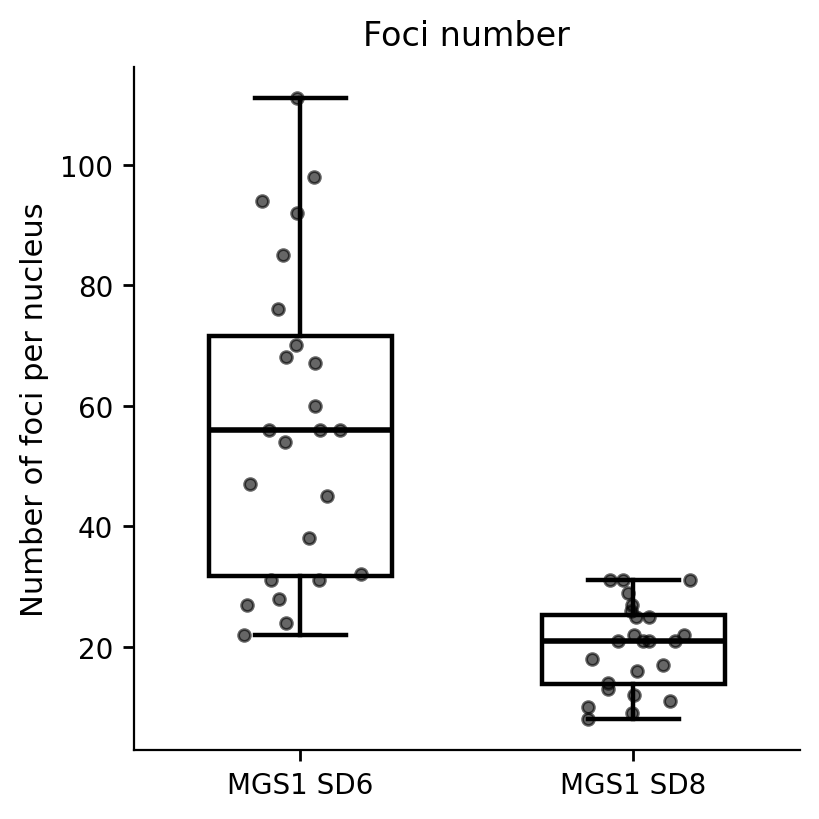

In [3]:
# Plotting
variables = ["Nucleus_area",  "Foci_MFI", "Foci_number"]
y_labels = {
    "Nucleus_area": "Nucleus area (µm²)",
    "Nucleus_MFI": "Nucleus mean fluorescence intensity (a.u.)",
    "Foci_MFI": "Foci mean fluorescence intensity (a.u.)",
    "Foci_number": "Number of foci per nucleus"
}
log_vars = {"Foci_MFI"}

plot_publication_boxplots(
    dfs=dfs,
    combined_df=combined_df,
    variables=variables,
    y_labels=y_labels,
    log_vars=log_vars
)

## Boxplots with t-test

Foci_MFI: t = -2.06, p = 4.682e-02


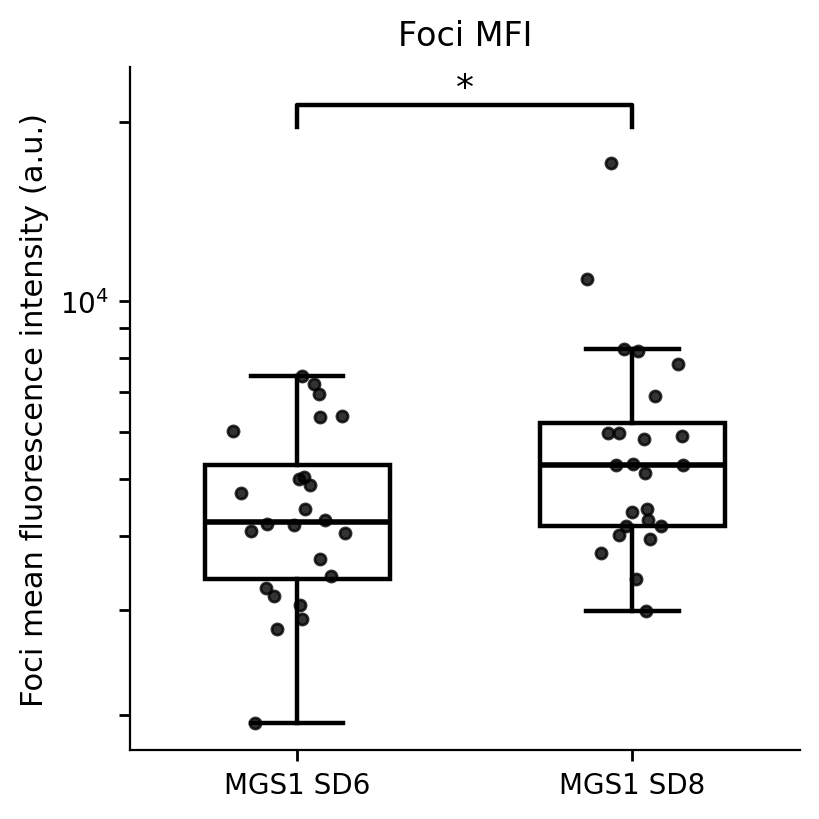

Foci_number: t = 6.74, p = 3.331e-07


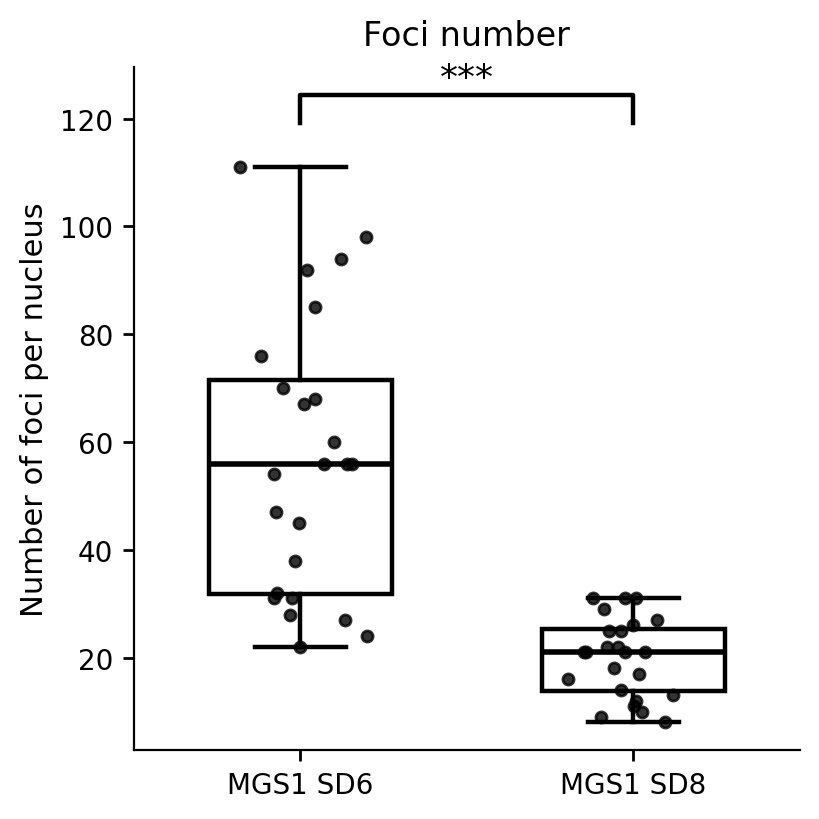

In [4]:
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

def add_sig_bracket(ax, x1, x2, y, h, text, fontsize=12):
    # square bracket
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.6, c="black", clip_on=False)
    ax.text((x1 + x2) / 2, y + h, text, ha="center", va="bottom", fontsize=fontsize)

def clean_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="both", which="both", direction="out", length=4, width=1)
    ax.grid(False)

variables = ["Foci_MFI", "Foci_number"]

groups = list(dfs.keys())
group1, group2 = groups[0], groups[1]

# Optional: use log scale for MFI (often helps)
log_vars = {"Foci_MFI"}  # or set() if you don't want log

for var in variables:

    fig, ax = plt.subplots(figsize=(4.2, 4.2), dpi=200)

    # Data
    data1 = combined_df.loc[combined_df["Group"] == group1, var].dropna()
    data2 = combined_df.loc[combined_df["Group"] == group2, var].dropna()

    # Welch t-test
    t_stat, p_value = ttest_ind(data1, data2, equal_var=False)
    stars = significance_stars(p_value)
    print(f"{var}: t = {t_stat:.2f}, p = {p_value:.3e}")

    # Boxplot (publication style)
    bp = ax.boxplot(
        [data1.values, data2.values],
        widths=0.55,
        showfliers=False,
        patch_artist=True,
        medianprops=dict(linewidth=2.0, color="black"),
        boxprops=dict(linewidth=1.6, color="black"),
        whiskerprops=dict(linewidth=1.6, color="black"),
        capprops=dict(linewidth=1.6, color="black")
    )

    # Transparent boxes (clean)
    for b in bp["boxes"]:
        b.set_facecolor("none")   # fully transparent
        b.set_alpha(1)

    # Jitter points (lighter)
    jitter = 0.08
    x1 = np.random.normal(1, jitter, size=len(data1))
    x2 = np.random.normal(2, jitter, size=len(data2))
    ax.scatter(x1, data1, s=16, alpha=0.8,color="black")
    ax.scatter(x2, data2, s=16, alpha=0.8, color="black")  

    # Labels (replace underscores with spaces)
    labels = [group1.replace("_", " "), group2.replace("_", " ")]
    ax.set_xticks([1, 2])
    ax.set_xticklabels(labels, fontsize=10)

    ax.set_ylabel(y_labels[var], fontsize=11)
    ax.set_title(var.replace("_", " "), fontsize=12, pad=8)

    # Optional log scale
    if var in log_vars:
        ax.set_yscale("log")

    # ---- bracket position based on data (robust) ----
    all_y = np.concatenate([data1.values, data2.values])
    y_max = np.nanmax(all_y)
    y_min = np.nanmin(all_y)
    yr = y_max - y_min if y_max > y_min else 1.0

    # for log-scale, place bracket multiplicatively
    if ax.get_yscale() == "log":
        y = y_max * 1.15
        h = y_max * 0.10
        add_sig_bracket(ax, 1, 2, y, h, stars, fontsize=13)
        ax.set_ylim(bottom=max(y_min * 0.9, 1e-12), top=y_max * 1.45)
    else:
        y = y_max + 0.08 * yr
        h = 0.05 * yr
        add_sig_bracket(ax, 1, 2, y, h, stars, fontsize=13)
        ax.set_ylim(y_min - 0.05 * yr, y_max + 0.18 * yr)

    clean_axes(ax)
    fig.tight_layout()
    plt.show()


# Spearman correlation visualization

In [5]:
def plot_scatter_dfs(
    dfs,
    col1,
    col2,
    figsize=(3, 3),
    dpi=300,
    log_x=False,
    log_y=False,
    show_regression=True
):
    """
    Plot scatter plots for multiple dataframes (dictionary format).

    Parameters:
        dfs : dict {name: dataframe}
        col1 : x-axis column name
        col2 : y-axis column name
        figsize : tuple
        dpi : int
        log_x : bool
        log_y : bool
        show_regression : bool
    """

    def clean_axes(ax):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis="both", direction="out", length=3, width=1)
        ax.grid(False)

    for name, data in dfs.items():

        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

        x = data[col1]
        y = data[col2]

        # Scatter
        ax.scatter(
            x, y,
            s=12,
            color="black",
            alpha=0.6,
            edgecolors="none"
        )

        # Regression
        if show_regression:
            slope, intercept, r_value, p_value, _ = linregress(x, y)
            xx = np.linspace(x.min(), x.max(), 100)
            yy = slope * xx + intercept
            ax.plot(xx, yy, color="black", linewidth=1)

            # R²
            ax.text(
                0.05, 0.95,
                f"$R^2$ = {r_value**2:.2f}",
                transform=ax.transAxes,
                ha="left",
                va="top",
                fontsize=8
            )

        # Labels
        ax.set_xlabel(col1.replace("_", " "), fontsize=9)
        ax.set_ylabel(col2.replace("_", " "), fontsize=9)
        ax.set_title(name.replace("_", " "), fontsize=10)

        if log_x:
            ax.set_xscale("log")
        if log_y:
            ax.set_yscale("log")

        clean_axes(ax)
        fig.tight_layout()
        plt.show()


In [6]:
df.columns

Index(['File_name', 'Nucleus_area', 'Nucleus_MFI', 'Foci_number', 'Foci_MFI'], dtype='str')

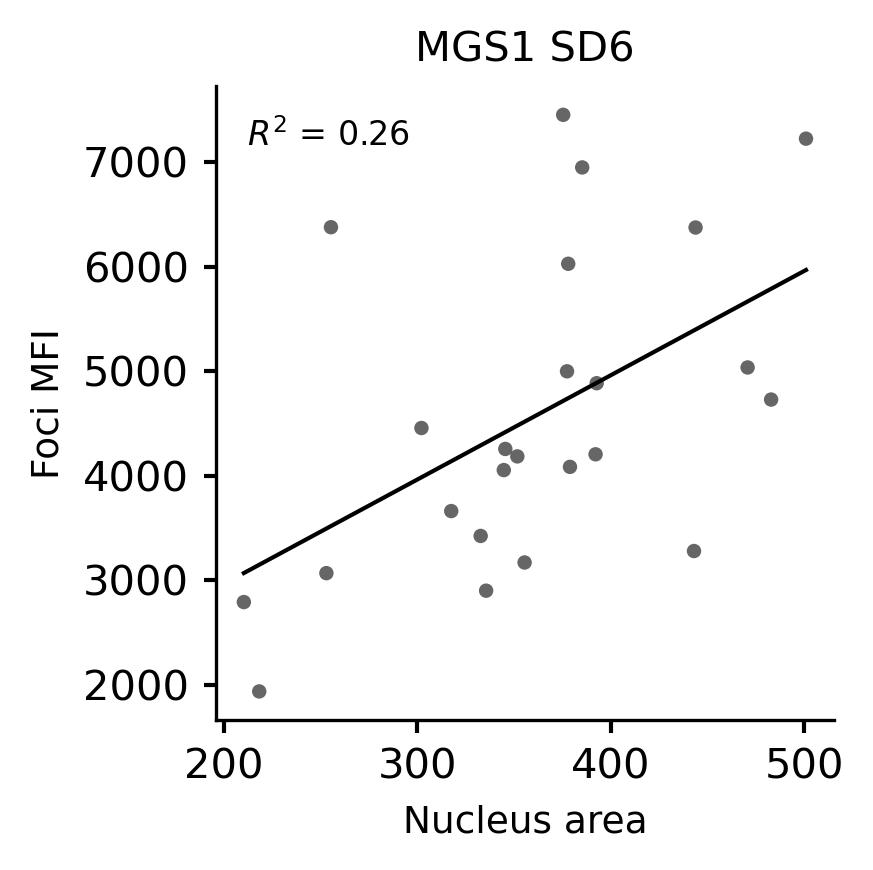

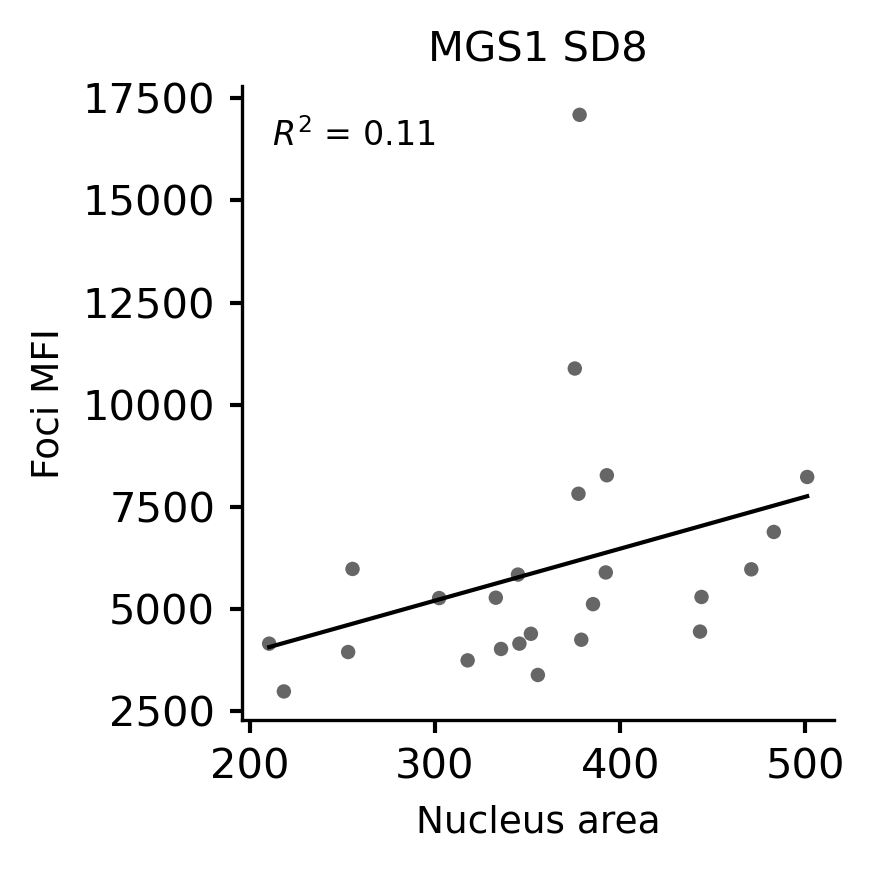

In [7]:
plot_scatter_dfs(dfs, "Nucleus_area", "Foci_MFI")

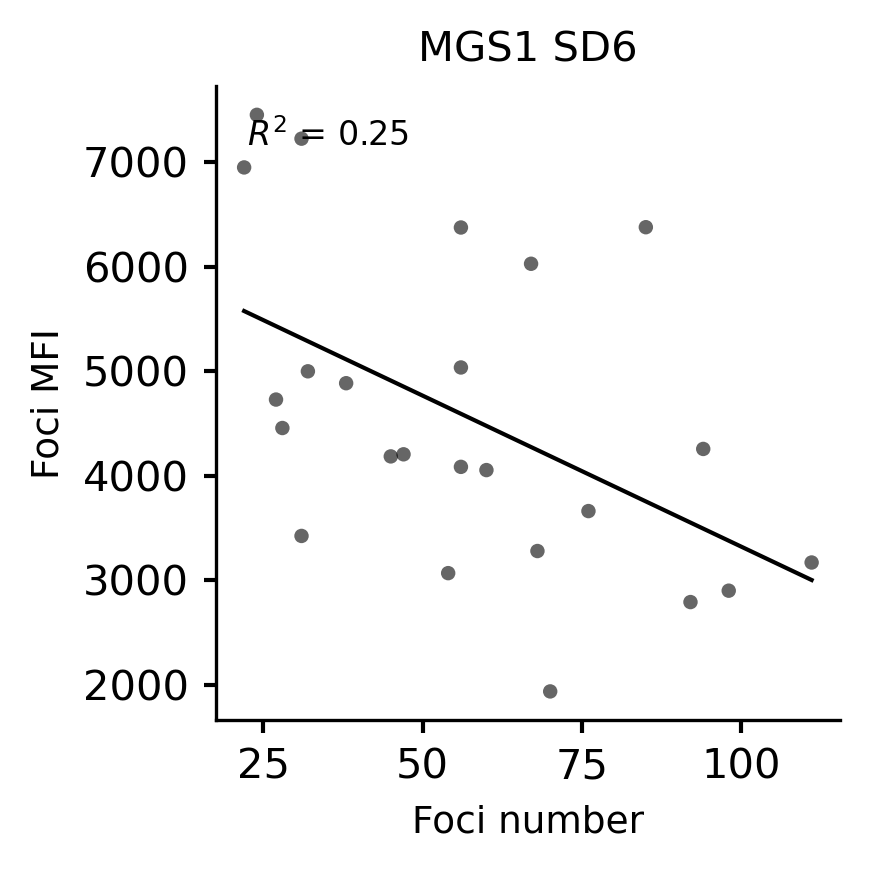

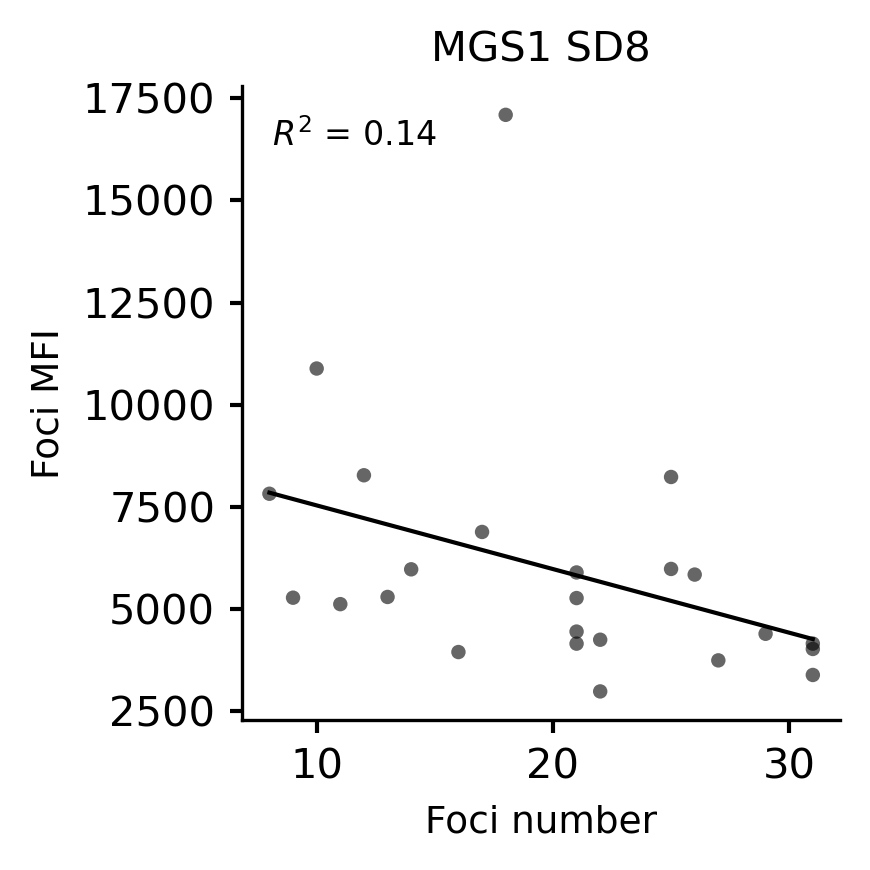

In [8]:
plot_scatter_dfs(dfs, "Foci_number", "Foci_MFI")